# Logistic regression for a binary classification with a non-linear classification boundary
## 20175437 융합공학부 디지털이미징전공 4학년 신준섭

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

## 1. Training Data

* loading datas from ```data-nonlinear.txt```
* each row $ \{ x^{(i)}, y^{(i)}, l^{(i)} \}$ od the data consists of 2D point $(x, y)$ with its label $l$
* since it is binary classification problem, and with real point $(x, y)$
$$(x, y) \in \mathbb{R},    l \in {0, 1} $$

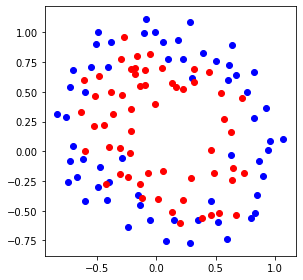

In [3]:
raw_data = np.genfromtxt("data-nonlinear.txt", delimiter=',')

pointX, pointY, label = raw_data[:, 0], raw_data[:, 1], raw_data[:, 2]

pointX0, pointY0 = pointX[label == 0], pointY[label == 0]
pointX1, pointY1 = pointX[label == 1], pointY[label == 1]

plt.scatter(pointX0, pointY0, c='b')
plt.scatter(pointX1, pointY1, c='r')
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')

## 1-1. Matrix representations

### 1) Defining the train data
$$ x_i = [1, x^{(i)}, y^{(i)}]^T$$
where this can be formed in Matrix representaion
\begin{gather}
    D = 
    \begin{bmatrix}
        x_1^T \\ ... \\ x_N^T
    \end{bmatrix}
    =
    \begin{bmatrix}
        1 & x_{1} & y_{1} \\ & ... & \\ 1 & x_{N} & y_{N}
    \end{bmatrix}
\end{gather}
for the label $l_{i} \in \{0, 1\}$
\begin{gather}
    L =
    \begin{bmatrix}
        l_1 \\ l_2 \\ ... \\ l_N
    \end{bmatrix}
\end{gather}

### 2) Defining the high dimensional function of $x$ and $y$
$$f_0(x, y) = 1, \hspace{1cm}  f_1(x, y) = x^2, \hspace{1cm} f_2(x, y) = y^2$$
$$f_3(x, y) = xy, \hspace{1cm} f_4(x, y) = x, \hspace{1cm} f_5(x, y) = y$$


### 3) Defining the Linear combination $g$
$$ g(x, y, \theta) = \sum_{k=0}^{M}\theta_k f_k(x, y) $$


### 4) All-in-one
since we are using 6 parameter $(M=6)$, real training matrix becomes
\begin{gather}
    F =
    \begin{bmatrix}
        1 & x_1^2 & y_1^2 & x_1 y_1 & x_1 & y_1 \\
          &       &       &  ...    &     & \\
        1 & x_N^2 & y_N^2 & x_N y_N & x_N & y_N 
    \end{bmatrix} ,
    \Theta = [\theta_0, \theta_1, \theta_2, \theta_3 \theta_4, \theta_5]^T
\end{gather}

where, the result of linear combination
$$G = F \Theta$$

In [4]:
N, M = len(label), 6
Xs = np.matrix(pointX.reshape(N, 1))
Ys = np.matrix(pointY.reshape(N, 1))
F = np.concatenate((np.ones((N, 1)), np.multiply(Xs, Xs), np.multiply(Ys, Ys), np.multiply(Xs, Ys), Xs, Ys), axis=1)
L = np.matrix(label).reshape(N, 1)

## 2. Logistic regression
* the sigmoid function for classification
$$\sigma(z) = \frac{1}{1+\exp\{-z\}}$$
* derivative of the sigmoid
$$\sigma^{'}(z) = \sigma(z)(1-\sigma(z))$$
* the linear combination
$$g(x, y, \theta) = \sum_{k=0}^{5} \theta_k f_k(x, y)$$

In [5]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-1.0 * z))

def lin_comb(F, T):
    return np.matmul(F, T)

## 3. Objective Function
$$J(\theta) = \frac{1}{N} \sum_{i=1}^N ( - l^{(i)} \log(\sigma(g(x^{(i)}, y^{(i)}; \theta))) - (1 - l^{(i)}) \log(1 - \sigma(g(x^{(i)}, y^{(i)}; \theta)))  )$$

In [6]:
def loss(F, T, L):
    normalizer_denominator = (1.0 / N)
    left_term = -1.0 * np.multiply(L, np.log(sigmoid(lin_comb(F, T))))
    right_term = np.multiply((1.0 - L), np.log(1.0 - sigmoid(lin_comb(F, T))))
    loss_in_row = left_term - right_term
    return normalizer_denominator * np.sum(loss_in_row)

## 4. Gradient Descent
$$ \theta_{k}^{(t+1)} := \theta_0^{(t)} - \alpha \frac{1}{N} \sum_{i=1}^N (\sigma(g(x^{(i)}, y^{(i)}; \theta)) - l^{(i)}) \frac{\partial g(x^{(i)}, y^{(i)}; \theta^{(t)})}{\partial \theta_{k}} $$

where the partial derivative $ \frac{\partial g}{\partial \theta_k} $ is just $f_k$
$$\frac{\partial g}{\partial \theta_k} = f_k(x,y)$$

the gradient of g is
$$\nabla g = [f_0, f_1, f_2, f_3, f_4, f_5]$$

In [7]:
def getGradient(F, T, L):
    normalizer = 1.0 / N
    difference = sigmoid(lin_comb(F, T)) - L
    grad = []
    for idx in range(M):
        grad.append(normalizer * np.sum(np.multiply(difference, F[:, idx])))
    
    return np.matrix(grad).reshape(T.shape)

def gradientDescent(F, T, L, lr):
    gradients = getGradient(F, T, L)
    return T - lr * gradients


## 5. Training

In [19]:
t = np.matrix([[0.0], [0.0], [0.0], [0.0], [0.0], [0.0]])
learning_rate = 1.0

T_record = t
loss_record = [10.0]
accuracy_record = []
iterations = 0

decay_count = 0
decay_max_count = 5

while True:
    loss_record.append(loss(F, t, L))
    t = gradientDescent(F, t, L, learning_rate)
    T_record = np.concatenate((T_record, t), axis=1)
    iterations = iterations + 1

    correct = np.sum(np.where(np.abs(sigmoid(lin_comb(F, t)) - L) < 0.5, 1.0, 0.0))
    accuracy_record.append(correct / N)

    if loss_record[-1] <= loss(F, t, L):
        if decay_count != decay_max_count:
            print("lr decay! ("+str(iterations)+ ") : " + str(learning_rate) + " -> " + str(learning_rate * 0.1))
            learning_rate = learning_rate * 0.1
            decay_count = decay_count + 1
        else:
            break

_ = loss_record.pop(0)
T_record = np.delete(T_record, 0, axis=1)
T_predict = t

lr decay! (19743) : 1.0 -> 0.1
lr decay! (19745) : 0.1 -> 0.010000000000000002
lr decay! (19746) : 0.010000000000000002 -> 0.0010000000000000002
lr decay! (19748) : 0.0010000000000000002 -> 0.00010000000000000003
lr decay! (19749) : 0.00010000000000000003 -> 1.0000000000000004e-05


## 6. Compute the training accuracy
$$\frac{\textrm{number of correct predictions}}{\textrm{total number of predictions}}$$

In [20]:
correct = np.sum(np.where(np.abs(sigmoid(lin_comb(F, T_predict)) - L) < 0.5, 1.0, 0.0))

print("accuracy of " + str(correct / N))

accuracy of 0.8559322033898306


# Answers for the submission

## 1. Plot the training data

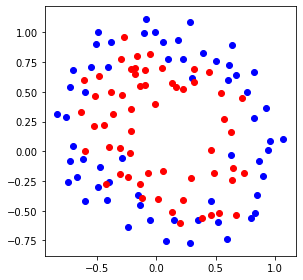

In [21]:
plt.scatter(pointX0, pointY0, c='b')
plt.scatter(pointX1, pointY1, c='r')
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

## 2. Write down the high dimensional function $g(x, y;\theta)$

$$f_0(x, y) = 1, \hspace{1cm}  f_1(x, y) = x^2, \hspace{1cm} f_2(x, y) = y^2$$
$$f_3(x, y) = xy, \hspace{1cm} f_4(x, y) = x, \hspace{1cm} f_5(x, y) = y$$

$$ g(x, y, \theta) = \sum_{k=0}^{5}\theta_k f_k(x, y) $$

## 3. Plot the training error

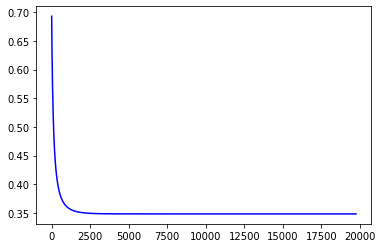

In [22]:
iter_x = list(range(iterations))

plt.plot(iter_x, loss_record, color='blue')
plt.show()

## 4. Plot the training accuracy

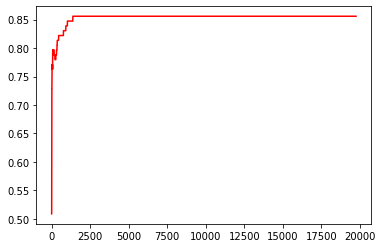

In [23]:
plt.plot(iter_x, accuracy_record, color = 'red')
plt.show()

## 5. Write down the final training accuracy

In [24]:
correct = np.sum(np.where(np.abs(sigmoid(lin_comb(F, T_predict)) - L) < 0.5, 1.0, 0.0))

print("final accuracy of " + str(correct / N))

final accuracy of 0.8559322033898306
